# Boston Data
- A data set containing housing values in 506 suburbs of Boston.
- There are 13 variables:
    - crim: Crime rate per person in each town.
    - zn: Percentage of residential land for large lots (over 25,000 sq. ft).
    - indus: Percentage of land used for non-retail businesses in each town.
    - chas: Whether the area borders the Charles River (1 = yes, 0 = no).
    - nox: Levels of nitrogen oxides in the air (per 10 million parts).
    - rm: Average number of rooms in homes.
    - age: Percentage of homes built before 1940.
    - dis: Average distance to five employment centers in Boston.
    - rad: Ease of access to highways.
    - tax: Property tax rate per $10,000.
    - ptratio: Student-to-teacher ratio in schools by town.
    - lstat: Percentage of lower-income residents.
    - medv: Median home value in thousands of dollars.


# Load Packages and Data

In [1]:
%%capture
pip install ISLP

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from ISLP.bart import BART

In [3]:
Boston = load_data("Boston")
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [4]:
Boston.describe().round(1)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0
mean,3.6,11.4,11.1,0.1,0.6,6.3,68.6,3.8,9.5,408.2,18.5,12.7,22.5
std,8.6,23.3,6.9,0.3,0.1,0.7,28.1,2.1,8.7,168.5,2.2,7.1,9.2
min,0.0,0.0,0.5,0.0,0.4,3.6,2.9,1.1,1.0,187.0,12.6,1.7,5.0
25%,0.1,0.0,5.2,0.0,0.4,5.9,45.0,2.1,4.0,279.0,17.4,7.0,17.0
50%,0.3,0.0,9.7,0.0,0.5,6.2,77.5,3.2,5.0,330.0,19.0,11.4,21.2
75%,3.7,12.5,18.1,0.0,0.6,6.6,94.1,5.2,24.0,666.0,20.2,17.0,25.0
max,89.0,100.0,27.7,1.0,0.9,8.8,100.0,12.1,24.0,711.0,22.0,38.0,50.0


# Fitting Regression Trees
- The steps are similar to those for classification trees.

In [9]:
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

- First, we split the data into training and test sets, using 30% for testing, and fit the tree to the training data.

In [6]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(
    X, Boston['medv'], test_size=0.3, random_state=0)

- After creating our training and test data sets, we fit the regression tree.

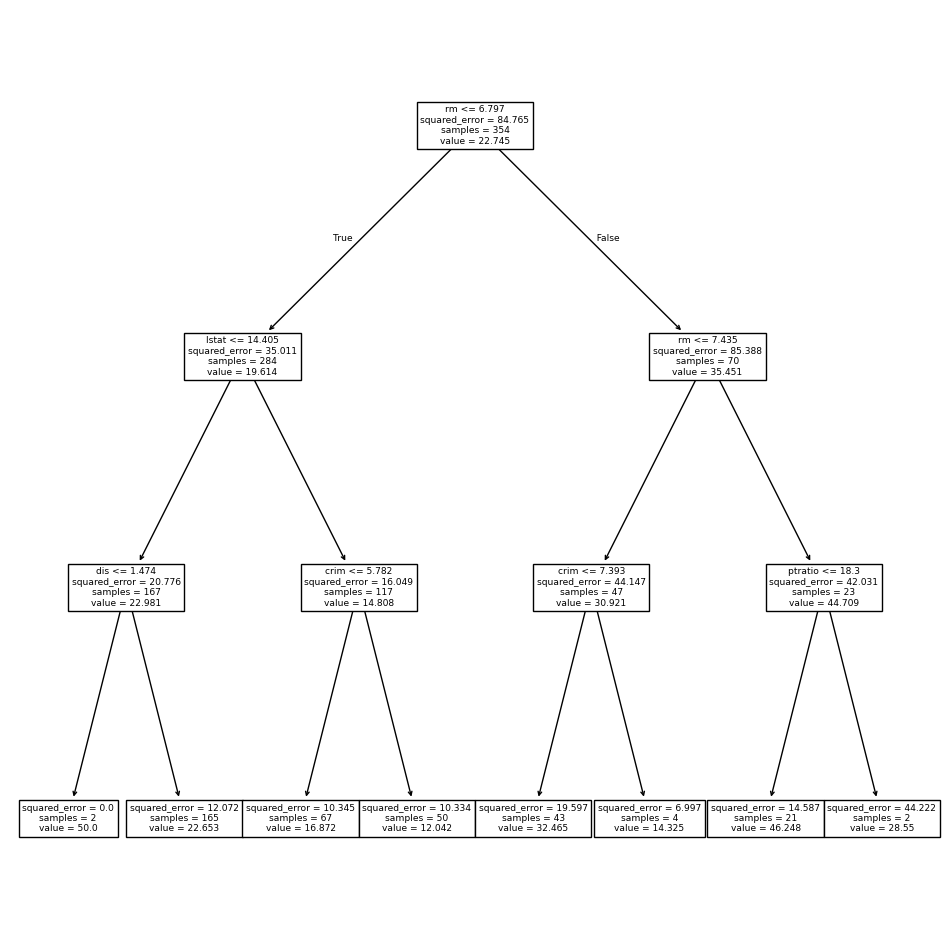

In [7]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg, feature_names=feature_names, ax=ax);

- The variable `lstat` represents the percentage of individuals with lower socioeconomic status. The tree analysis reveals that lower values of `lstat` are linked to more expensive houses.
- For example, it predicts a median house price of $12,042 for small homes (`rm < 6.8`) located in areas where the socioeconomic status is low (`lstat > 14.4`) and the crime rate is moderate (`crim > 5.8`).

- We now use cross-validation to determine if pruning the tree improves performance.

In [8]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(reg, {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

- Based on the cross-validation results, we use the pruned tree to make predictions on the test set.

In [10]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.06985754975404

- The test set MSE for the regression tree is 28.07, which results in a square root of about 5.30. This means the model's predictions are typically within $5,300 of the actual median home value for the suburb.
- Now, let’s plot the best tree to see how easy it is to interpret.

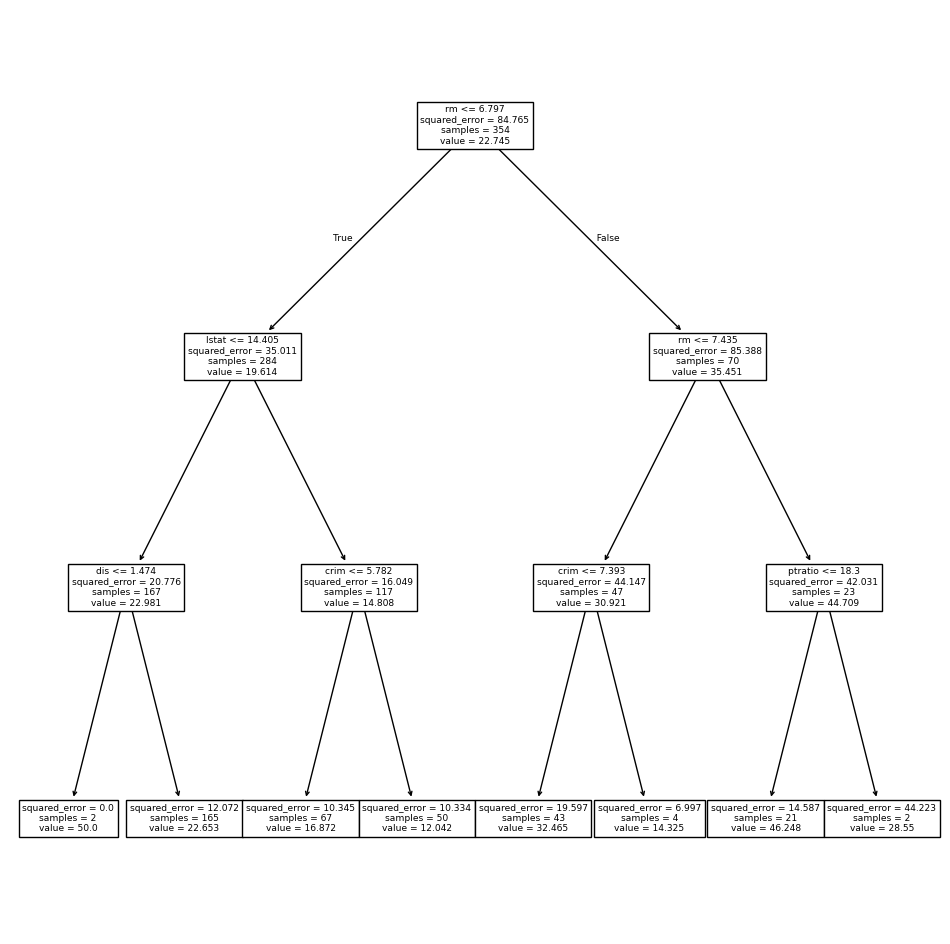

In [11]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_, feature_names=feature_names, ax=ax);

# Bagging and Random Forests

- We apply bagging and random forests to the `Boston` data using the `RandomForestRegressor()` from the `sklearn.ensemble` package.
- Remember, bagging is a specific case of a random forest where m = p. Thus, the `RandomForestRegressor()` function can handle both bagging and random forests. We'll begin with bagging.

In [12]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

- The `max_features` argument specifies that all 12 predictors should be considered for each tree split, indicating that we're using bagging.
- Now, let's evaluate how well this bagged model performs on the test set.

14.605662565263161

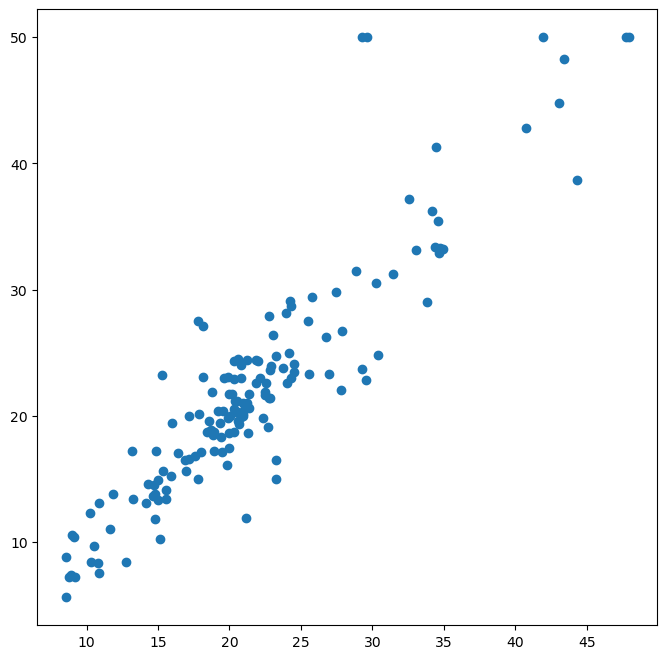

In [17]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

- The test set MSE for the bagged regression tree is 14.63, roughly half of that achieved with an optimally pruned single tree.
- We can adjust the number of trees grown from the default of 100 by using the `n_estimators` argument.

In [18]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161

- There is not change.
- There is no risk of overfitting when increasing the number of trees in bagging and random forests; however, having too few trees can lead to underfitting.
- Growing a random forest is similar to bagging, but with a smaller `max_features` value.
    - By default, `RandomForestRegressor()` uses all $p$ variables (defaulting to bagging), while `RandomForestClassifier()` uses $\sqrt{p}$  variables. In this case, we set `max_features=6`.

In [19]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

20.04276446710527

- The test set MSE for the random forest is 20.04, indicating that it performed somewhat worse than bagging in this case.
- By extracting the `feature_importances_` values from the fitted model, we can analyze the importance of each variable.

In [20]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


- This is a relative measure of the total decrease in node impurity achieved by splits on each variable, averaged across all trees (as shown in Figure of the book for the `Heart` data).
- The results show that, among all the trees in the random forest, the community's wealth level (`lstat`) and the house size (`rm`) are the two most important variables by far.

# Boosting

- We use `GradientBoostingRegressor()` from `sklearn.ensemble` to fit boosted regression trees to the `Boston` data set. For classification, we would use `GradientBoostingClassifier()`. 
- The argument:
    - `n_estimators=5000` specifies that we want to create 5,000 trees
    - `max_depth=3` limits the depth of each tree
    - `learning_rate` parameter corresponds to the $\lambda$ discussed earlier in the description of boosting.

In [21]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

- We can track the decrease in training error using the `train_score_` attribute.
- To observe how the test error decreases, we can use the `staged_predict()` method to obtain predicted values at each stage of the model.

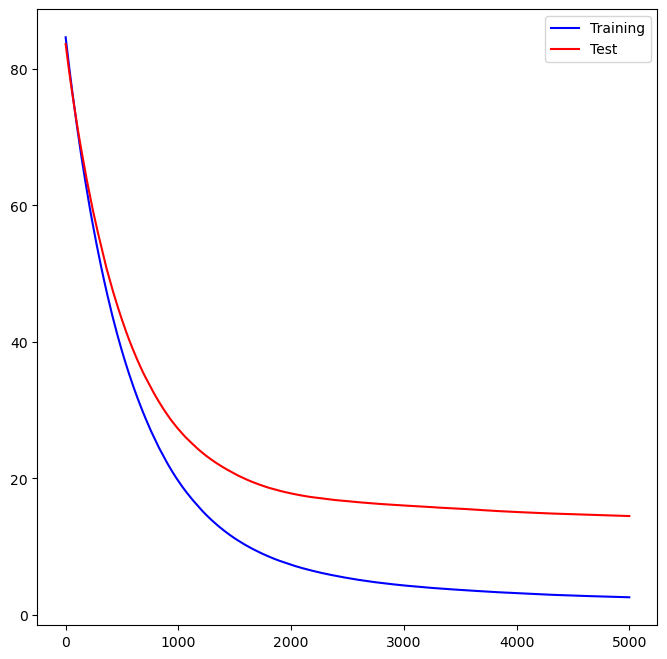

In [22]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

- We use the boosted model to predict `medv` on the test set.

In [23]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.481405918831591

- The test MSE obtained is 14.48, similar to the MSE for bagging.
- We can perform boosting with a different shrinkage parameter $\lambda$. The default value is 0.001, but we can easily change it; here, we set $\lambda=0.2$.

In [24]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.501514553719565

- In this case, using $\lambda=0.2$ leads to a almost the same test MSE as when using $\lambda=0.001$.

# Bayesian Additive Regression Trees

- In this section, we demonstrate a `Python` implementation of BART using the `ISLP.bart` package, fitting a model to the `Boston` housing data set.
- The `BART()` estimator is tailored for quantitative outcome variables, although other implementations exist for logistic and probit models for categorical outcomes.

In [25]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

- On this data set, with the given train-test split, the test error of BART is comparable to that of the random forest.

In [26]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

22.145009458109225

- We can check the frequency of each variable's appearance across the collection of trees, providing a summary similar to the variable importance plot for boosting and random forests.

In [35]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                               index=D.columns)
var_inclusion


crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64